In [1]:
import pandas as pd
import nltk # imports the natural language toolkit
nltk.download('punkt')
nltk.download('stopwords')
import numpy  as np
import string
import plotly
from nltk.stem import PorterStemmer 
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from langdetect import detect_langs
from nltk.corpus import stopwords
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/priankaball/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/priankaball/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


## Data Exploration

In [102]:
import json

def load_rows(filepath, nrows = None):
    with open(filepath) as json_file:
        count = 0
        objs = []
        line = json_file.readline()
        while (nrows is None or count < nrows) and line:
            count += 1
            obj = json.loads(line)
            objs.append(obj)
            line = json_file.readline()
        return pd.DataFrame(objs)

In [103]:
business = load_rows('yelp_academic_dataset_business.json',10000)
print('Business objects loaded. Count = {}'.format(business.shape[0]))

Business objects loaded. Count = 10000


In [104]:
review = load_rows('yelp_academic_dataset_review.json',10000)
print('checkin objects loaded. Count = {}'.format(review.shape[0]))

checkin objects loaded. Count = 10000


In [105]:
business.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')

In [106]:
review.columns

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object')

In [107]:
#keeping business that are still open 
# 1 = open, 0 = closed
business = business[business['is_open']==1]

In [108]:
#removing columns that might not be relevant
business = business.drop(['hours','is_open','address', 'postal_code', 'attributes', 'review_count', 'city', 'latitude','longitude'], axis=1)

In [109]:
business.columns

Index(['business_id', 'name', 'state', 'stars', 'categories'], dtype='object')

<AxesSubplot:>

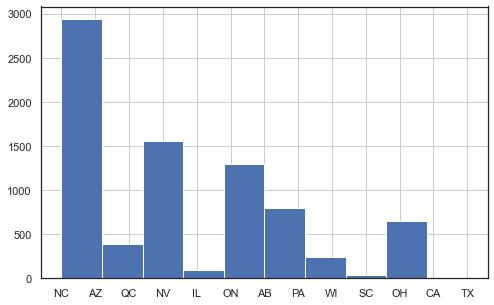

In [110]:
business['state'].hist()

In [111]:
business.dtypes

business_id     object
name            object
state           object
stars          float64
categories      object
dtype: object

In [112]:
#filter for restaurnats
business_res = business[business['categories'].str.contains(
              'Restaurants',
              case=False, na=False)]

In [113]:
business_res.nunique()

business_id    2048
name           1725
state            12
stars             9
categories     1519
dtype: int64

In [114]:
business_res['categories'].unique()

array(['Ethnic Food, Food Trucks, Specialty Food, Imported Food, Argentine, Food, Restaurants, Empanadas',
       'Restaurants, Cheesesteaks, Poutineries',
       'Japanese, Fast Food, Food Court, Restaurants', ...,
       'Sandwiches, Restaurants, Food, Donuts, Coffee & Tea',
       'Restaurants, Pizza, Chicken Wings, Food, Desserts',
       'Restaurants, Indian, Nightlife, Pakistani, Hookah Bars, Mediterranean, Bars'],
      dtype=object)

In [115]:
business_res['categories'].unique()

array(['Ethnic Food, Food Trucks, Specialty Food, Imported Food, Argentine, Food, Restaurants, Empanadas',
       'Restaurants, Cheesesteaks, Poutineries',
       'Japanese, Fast Food, Food Court, Restaurants', ...,
       'Sandwiches, Restaurants, Food, Donuts, Coffee & Tea',
       'Restaurants, Pizza, Chicken Wings, Food, Desserts',
       'Restaurants, Indian, Nightlife, Pakistani, Hookah Bars, Mediterranean, Bars'],
      dtype=object)

In [116]:
business_res['categories'].nunique()

1519

In [117]:
business_res = business_res.rename(columns={'stars': 'business_stars'})

In [118]:
#business have multiple categories. Each category is each row
df_explode = business.assign(categories = business.categories
                         .str.split(', ')).explode('categories')

In [119]:
df_explode['categories'].unique()

array(['Active Life', 'Gun/Rifle Ranges', 'Guns & Ammo', ...,
       'Concept Shops', 'Party Bike Rentals', 'Bangladeshi'], dtype=object)

In [120]:
df_explode['categories'].nunique()

1054

In [121]:
df_explode.categories.value_counts().head(10)# most of the category is restaurant

Restaurants                  2048
Shopping                     1338
Food                         1152
Home Services                 962
Health & Medical              832
Beauty & Spas                 757
Local Services                707
Automotive                    617
Nightlife                     467
Event Planning & Services     465
Name: categories, dtype: int64

In [122]:
df_explode[df_explode.categories.str.contains('Restaurants',
                      case=True,na=False)].categories.value_counts()

Restaurants    2048
Name: categories, dtype: int64

In [123]:
df_explode[df_explode.categories.str.contains('Restaurants',
                      case=True,na=False)]

,business_id,name,state,stars,categories
8,pQeaRpvuhoEqudo3uymHIQ,The Empanadas House,IL,4.5,Restaurants
24,eBEfgOPG7pvFhb2wcG9I7w,Philthy Phillys,ON,4.5,Restaurants
25,lu7vtrp_bE9PnxWfA8g4Pg,Banzai Sushi,ON,4.5,Restaurants
30,9sRGfSVEfLhN_km60YruTA,Apadana Restaurant,ON,3.0,Restaurants
33,vjTVxnsQEZ34XjYNS-XUpA,Wetzel's Pretzels,AZ,4.0,Restaurants
...,...,...,...,...,...
9988,id_4VpPvd3zR0q_qhasUNQ,Dunkin',PA,1.5,Restaurants
9989,qCSWNJ2ClIaO5XTfzsiYFA,El Valle Mexican Restaurant,NC,3.5,Restaurants
9990,Mp50uBWoZAXqSjaIZB7iow,Del Taco,AZ,2.5,Restaurants
9993,Qt3hE9Ozypa2uJkEaRHJ8w,Papa John's,AB,1.5,Restaurants


In [124]:
review.dtypes

review_id       object
user_id         object
business_id     object
stars          float64
useful           int64
funny            int64
cool             int64
text            object
date            object
dtype: object

In [125]:
#removing columns that might not be relevant
review = review.drop(['useful','user_id','funny', 'cool', 'date'], axis=1)

In [126]:
review.head()

,review_id,business_id,stars,text
0,xQY8N_XvtGbearJ5X4QryQ,-MhfebM0QIsKt87iDN-FNw,2.0,"As someone who has worked with many museums, I..."
1,UmFMZ8PyXZTY2QcwzsfQYA,lbrU8StCq3yDfr-QMnGrmQ,1.0,I am actually horrified this place is still in...
2,LG2ZaYiOgpr2DK_90pYjNw,HQl28KMwrEKHqhFrrDqVNQ,5.0,I love Deagan's. I do. I really do. The atmosp...
3,i6g_oA9Yf9Y31qt0wibXpw,5JxlZaqCnk1MnbgRirs40Q,1.0,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g..."
4,6TdNDKywdbjoTkizeMce8A,IS4cv902ykd8wj1TR0N3-A,4.0,"Oh happy day, finally have a Canes near my cas..."


In [127]:
review = review.rename(columns={'stars': 'review_stars'})

In [128]:
final = pd.merge(business_res, review, on='business_id', how='inner')

In [129]:
final.head()

,business_id,name,state,business_stars,categories,review_id,review_stars,text
0,pQeaRpvuhoEqudo3uymHIQ,The Empanadas House,IL,4.5,"Ethnic Food, Food Trucks, Specialty Food, Impo...",2TtLt9skrBwBM6QGEhFYCg,5.0,I love the empanadas from the Empanadas House!...
1,0QjROMVW9ACKjhSEfHqNCQ,Mi Mi Restaurant,ON,4.0,"Vietnamese, Restaurants",k8oDucABRxXtd7c95jK3Fg,5.0,Delicious delicous declicous!! It is my go-to ...
2,0QjROMVW9ACKjhSEfHqNCQ,Mi Mi Restaurant,ON,4.0,"Vietnamese, Restaurants",1cIe4ifcSvXy4lBS3cXHNA,4.0,"As a Vietnamese person, I highly recommend thi..."
3,0QjROMVW9ACKjhSEfHqNCQ,Mi Mi Restaurant,ON,4.0,"Vietnamese, Restaurants",ucm7wk4DjWmVb-bVcA1-nQ,5.0,Been going to Mi Mi Restaurant for years! I lo...
4,0QjROMVW9ACKjhSEfHqNCQ,Mi Mi Restaurant,ON,4.0,"Vietnamese, Restaurants",QDSIB6w9PJtcopN1Ua7esw,5.0,Our go-to place for Vietnamese food! This plac...


In [130]:
final.dtypes

business_id        object
name               object
state              object
business_stars    float64
categories         object
review_id          object
review_stars      float64
text               object
dtype: object

In [131]:
final['state'].unique()#have places in canada too

array(['IL', 'ON', 'AZ', 'OH', 'PA', 'NC', 'NV', 'QC', 'SC', 'AB', 'WI'],
      dtype=object)

In [132]:
final.shape

(2632, 8)

In [133]:
final.nunique() #number of unique values

business_id        800
name               745
state               11
business_stars       9
categories         682
review_id         2632
review_stars         5
text              2632
dtype: int64

In [34]:
final.isna().sum() # no NA's

business_id       0
name              0
state             0
business_stars    0
categories        0
review_id         0
review_stars      0
text              0
dtype: int64

In [35]:
final.describe()

,business_stars,review_stars
count,2632.000000,2632.000000
mean,3.763868,3.803571
std,0.603894,1.348373
min,1.000000,1.000000
25%,3.500000,3.000000
50%,4.000000,4.000000
75%,4.000000,5.000000
max,5.000000,5.000000


In [134]:
#selecting stars and text of reviews
df1 = final[['review_stars', 'text']]

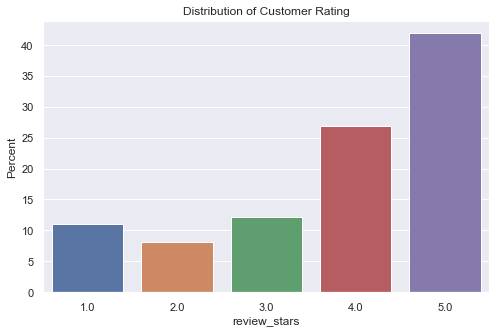

In [37]:
sns.set(rc={'figure.figsize':(8,5)})

#there are more 5 star reviews so we would need to normalize it
ax = sns.barplot(data=df1, x='review_stars', y='review_stars', estimator=lambda x: len(x) / len(df1) * 100)
ax.set(ylabel="Percent")
plt.title('Distribution of Customer Rating')
plt.show()

In [38]:
#We know from past analysis that there is foreign language in this dataset. 
language = [detect_langs(i) for i in df1.text]
languages = [str(i[0]).split(':')[0] for i in language]
df1['language'] = languages

<ipython-input-38-a6334dfa1450>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['language'] = languages


In [39]:
df1['language'].unique()# There is non-english reviews

array(['en', 'fr', 'no', 'ko', 'es', 'de'], dtype=object)

In [40]:
df1.groupby('language')['text'].nunique() #There are 11 non-english reviews

language
de       1
en    2622
es       2
fr       5
ko       1
no       1
Name: text, dtype: int64

In [41]:
df1 = df1.loc[df1["language"].isin(["en"])]#include reviews that are only in english

In [42]:
df1.nunique()

review_stars       5
text            2622
language           1
dtype: int64

In [45]:
only_review  = final['text']

<AxesSubplot:>

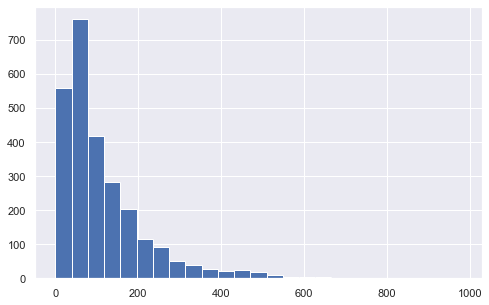

In [46]:
#most reviews were around 100
review_words_lengths = only_review.apply(lambda x: len(nltk.word_tokenize(x)))
review_words_lengths.hist(bins = 25)

In [47]:
min(review_words_lengths)

1

In [48]:
max(review_words_lengths)

979

In [49]:
#making list of stop words
my_stop_words = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS)+
                   ['u', 'will', 'still', 'Ive', 'Iam', 'm', 'I', 've'])
#hard to exclude I've and I'm
#to include more stop words

In [50]:
GoodInd = df1['review_stars'] >3.9 # All reviews with more than 3.9 stars
GoodRev = df1[GoodInd]

BadInd = df1['review_stars'] < 4 # All reviews with more than 3.9 stars
BadRev = df1[BadInd]

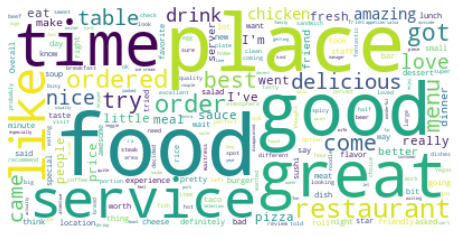

In [51]:
#making word cloud to make sure that we dont need more stop words
#this is the general word cloud with all data
from wordcloud import WordCloud
# concatenate all the reviews into one single string 
full_text = ' '.join(df1['text']) #only has the text data. This is also used later

cloud_no_stopword = WordCloud(background_color='white', stopwords=my_stop_words).generate(full_text)
plt.imshow(cloud_no_stopword, interpolation='bilinear')
plt.axis('off')
plt.show()

In [52]:
def word_cloud_rating(data,star_value):
    
    #data_filtered = data[data.review_stars == star_value] #filtering according to the star value
    data_filtered = data[data.review_stars.isin(star_value)]
    Reviews = data_filtered.text

    Reviews_text = ' '.join(Reviews.values) #joining all the words together


    # Creating a word cloud object
    wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white",\
                          scale = 10,width=800, height=400, stopwords=my_stop_words).generate(Reviews_text)

    # Plotting the generated word cloud
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

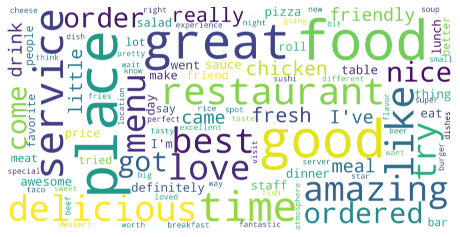

In [53]:
#wordcloud with 4 and 5 rating
word_cloud_rating(df1,[4,5])

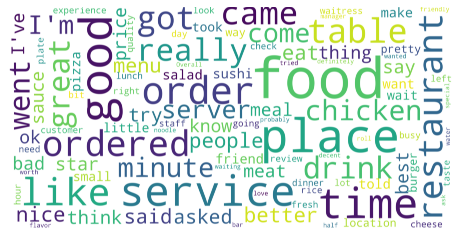

In [54]:
#wordcloud with 1,2,3 rating
word_cloud_rating(df1,[1,2,3])

In [55]:
#good is included in both
#First 5 reviews of so with 1 star and contains the word good. Here good has been used in a negative way
reviews_containing_good = [each for each in final[final.review_stars == 1].text if 'good' in each]
for review in reviews_containing_good[:20]:
    good_index = review.find("good")
    print(review[good_index-20:good_index+20].replace("\n", ""))

 is going to be any good - the salsa was
ortunately the only good thing I have to
tting. The food was good, no complaints 
ld suck but overall good service. I'm no
hed restaurant with good food has deteri
. The tacos are not good. Cold. Hard. To
 food tasted really good. My boyfriend h
ess I've always had good sushi rice that
rything was so very good. Last night pro


e is , the food was good but it can't ma
 shot.    So not a good experience.  If
k and the sushi was good.  You could tel
less were less than good. Boo Al's. Also
we received was NOT good. Our waiters we
this place might be good for you. I on t
e yet!! Food wasn't good, horrible quali

g else didn't taste good either. This wa


In [56]:
#First 5 reviews of so with 5 star and contains the word good. Here good has been used in a positive way
reviews_containing_good = [each for each in final[final.review_stars == 5].text if 'good' in each]
for review in reviews_containing_good[:20]:
    good_index = review.find("good")
    print(review[good_index-20:good_index+20].replace("\n", ""))
    
#Negated words are a big issue in this dataset

hop with rice is so good and flavourful 
i's. It's just that good. But if you are
owever, the food is good and that's what
 ice cream is super good. Really busy bu
you always get very good conversation wh

ut trust me, it's a good thing. Especial
sant,  the food was good.   We ordered t
an,  the food is as good as, if not bett

 The salad was very good. The lomein had
nd it does it for a good price. Lotus Ro
nce. The menu has a good variety, and ou
Everything was so good I will be back!
ilk teas are pretty good and light on th
who cares with such good food!  We tried
ere taken Extremely good care of by the 
ries are also super good!
s delicious ! So so good! Can't wait to 



In [57]:
#finding most used adjectives in good reviews and bad reviews. Only doing 500
one_star_reviews = final[final['review_stars']<4]['text'][:500]
five_star_reviews = final[final['review_stars']>3.9]['text'][:500]


def extract_specific_pos(reviews, pos_tag):
    results = [] 
    for review in reviews:
        words = nltk.word_tokenize(review)
        tagged = nltk.pos_tag(words)
        keep = [x[0] for x in tagged if x[1] == pos_tag]
        results += keep
    return results


negative_adjectives = extract_specific_pos(one_star_reviews, "JJ")
positive_adjectives = extract_specific_pos(five_star_reviews, "JJ")

print(Counter(negative_adjectives).most_common(30))
print(Counter(positive_adjectives).most_common(30))

[('good', 285), ('other', 114), ('great', 91), ('nice', 84), ('bad', 69), ('first', 68), ('few', 57), ('little', 57), ('small', 55), ('much', 49), ('busy', 47), ('last', 44), ('many', 41), ('same', 39), ('special', 37), ('decent', 37), ('fresh', 34), ('sure', 33), ('big', 33), ('friendly', 31), ('different', 31), ('ok', 31), ('next', 31), ('delicious', 30), ('terrible', 30), ('hot', 29), ('high', 29), ('tasty', 29), ('whole', 27), ('dry', 27)]
[('good', 259), ('great', 220), ('fresh', 77), ('delicious', 73), ('little', 71), ('friendly', 70), ('nice', 68), ('other', 53), ('few', 53), ('first', 48), ('amazing', 47), ('favorite', 43), ('awesome', 41), ('excellent', 36), ('small', 35), ('many', 34), ('next', 34), ('much', 34), ('new', 33), ('super', 33), ('sure', 32), ('different', 31), ('big', 31), ('tasty', 30), ('Good', 28), ('clean', 26), ('only', 26), ('hot', 26), ('last', 24), ('perfect', 23)]


In [58]:
negative_nouns = extract_specific_pos(one_star_reviews, "NN")
positive_nouns = extract_specific_pos(five_star_reviews, "NN")

print(Counter(negative_nouns).most_common(30))
print(Counter(positive_nouns).most_common(30))

[('food', 422), ('place', 241), ('service', 237), ('time', 202), ('order', 164), ('restaurant', 121), ('menu', 87), ('table', 84), ('server', 73), ('sushi', 70), ('experience', 67), ('chicken', 66), ('sauce', 60), ('meat', 59), ('meal', 59), ('pizza', 59), ('rice', 58), ('nothing', 57), ('way', 56), ('drink', 55), ('dinner', 53), ('location', 52), ('staff', 52), ('salad', 52), ('i', 50), ('night', 49), ('water', 49), ('lunch', 48), ('waitress', 48), ('something', 47)]
[('place', 307), ('food', 262), ('service', 131), ('time', 121), ('order', 76), ('chicken', 76), ('menu', 74), ('restaurant', 73), ('staff', 68), ('dinner', 58), ('sushi', 58), ('night', 56), ('pizza', 53), ('lunch', 51), ('salad', 51), ('sauce', 48), ('meal', 48), ('bar', 46), ('rice', 45), ('day', 44), ('experience', 44), ('area', 44), ('way', 43), ('side', 41), ('spot', 37), ('soup', 37), ('price', 37), ('roll', 37), ('cream', 37), ('meat', 36)]


In [59]:
#word tokenization
from nltk.tokenize import word_tokenize
from nltk import FreqDist

lower_full_text = full_text.lower()# all lower case
word_tokens = word_tokenize(lower_full_text) #tokenizing all the words

tokens = list() 
for word in word_tokens:
    if word.isalpha() and word not in my_stop_words:#exclude all stop words
        tokens.append(word)
        
token_dist = FreqDist(tokens)
dist = pd.DataFrame(token_dist.most_common(20),columns=['Word', 'Frequency'])
dist # top 20 common words


,Word,Frequency
0,food,1963
1,good,1598
2,place,1411
3,great,1252
4,service,1071
5,like,878
6,time,761
7,really,648
8,restaurant,587
9,ordered,587


In [60]:
#Top words after stemming. includes all reviews
from nltk.stem import PorterStemmer
porter = PorterStemmer()
stemmed_tokens =[porter.stem(word) for word in tokens]
stemmed_token_dist = FreqDist(stemmed_tokens)
stemmed_dist = pd.DataFrame(stemmed_token_dist.most_common(20),columns=['Word', 'Frequency'])
stemmed_dist

,Word,Frequency
0,food,1982
1,good,1627
2,place,1625
3,order,1266
4,great,1253
5,servic,1091
6,time,1002
7,like,991
8,tri,787
9,restaur,702


In [61]:
#High frequency words of good reviews, reviews more than 3.9
GoodInd = df1['review_stars'] >3.9 # All reviews with more than 3.9 stars
GoodRev = df1[GoodInd]
full_text_good = ' '.join(GoodRev['text'])

lower_full_text_good = full_text_good.lower()# all lower case
word_tokens_good = word_tokenize(lower_full_text_good) #tokenizing all the words

tokens_good = list() 
for word in word_tokens_good:
    if word.isalpha() and word not in my_stop_words:#exclude all stop words
        tokens_good.append(word)
        
token_dist_good = FreqDist(tokens_good)
dist_good = pd.DataFrame(token_dist_good.most_common(20),columns=['Word', 'Frequency'])
dist_good

,Word,Frequency
0,food,1177
1,good,1089
2,great,1068
3,place,990
4,service,658
5,like,512
6,time,442
7,delicious,423
8,best,418
9,really,417


In [62]:
#High frequency stemmed words of good reviews
#dont think stemming words gives good result
porter_good = PorterStemmer()
stemmed_tokens_good =[porter_good.stem(word) for word in tokens_good]
stemmed_token_dist_good = FreqDist(stemmed_tokens_good)
stemmed_dist_good = pd.DataFrame(stemmed_token_dist_good.most_common(20),columns=['Word', 'Frequency'])
stemmed_dist_good

,Word,Frequency
0,food,1189
1,place,1128
2,good,1109
3,great,1069
4,servic,669
5,order,661
6,like,590
7,time,578
8,love,572
9,tri,548


In [63]:
#High frequency words of bad reviews, reviews that are less than 4
BadInd = df1['review_stars'] < 4 # All reviews with more than 3.9 stars
BadRev = df1[BadInd]
full_text_bad = ' '.join(BadRev['text'])

lower_full_text_bad = full_text_bad.lower()# all lower case
word_tokens_bad = word_tokenize(lower_full_text_bad) #tokenizing all the words

tokens_bad = list() 
for word in word_tokens_bad:
    if word.isalpha() and word not in my_stop_words:#exclude all stop words
        tokens_bad.append(word)
        
token_dist_bad = FreqDist(tokens_bad)
dist_bad = pd.DataFrame(token_dist_bad.most_common(20),columns=['Word', 'Frequency'])
dist_bad

,Word,Frequency
0,food,786
1,good,509
2,place,421
3,service,413
4,like,366
5,time,319
6,ordered,267
7,order,264
8,really,231
9,got,228


In [64]:
#High frequency stemmed words of bad reviews
porter_bad = PorterStemmer()
stemmed_tokens_bad =[porter_bad.stem(word) for word in tokens_bad]
stemmed_token_dist_bad = FreqDist(stemmed_tokens_bad)
stemmed_dist_bad = pd.DataFrame(stemmed_token_dist_bad.most_common(20),columns=['Word', 'Frequency'])
stemmed_dist_bad

,Word,Frequency
0,food,793
1,order,605
2,good,518
3,place,497
4,time,424
5,servic,422
6,like,401
7,restaur,257
8,tabl,241
9,tri,239


In [65]:
#most frequent bi-grams of all reviews
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(stop_words=my_stop_words, ngram_range=(2,2))#exclude stop words

bigrams = vect.fit_transform(df1['text'])
bigram_df = pd.DataFrame(bigrams.toarray(), columns=vect.get_feature_names())
bigram_frequency = pd.DataFrame(bigram_df.sum(axis=0)).reset_index()
bigram_frequency.columns = ['bigram', 'frequency']
bigram_frequency = bigram_frequency.sort_values(by='frequency', ascending=False).head(20)
bigram_frequency

/usr/local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['iam', 'ive'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


,bigram,frequency
29530,food good,119
38511,ice cream,110
62643,really good,99
29535,food great,88
34743,great service,86
36947,highly recommend,86
60328,pretty good,85
34519,great food,81
33242,good food,75
18700,customer service,75


In [66]:
#bi-gram of good reviews
vect = CountVectorizer(stop_words=my_stop_words, ngram_range=(2,2))#exclude stop words

bigrams_good = vect.fit_transform(GoodRev['text'])


bigram_df_good = pd.DataFrame(bigrams_good.toarray(), columns=vect.get_feature_names())
bigram_frequency_good = pd.DataFrame(bigram_df_good.sum(axis=0)).reset_index()
bigram_frequency_good.columns = ['bigram', 'frequency']
bigram_frequency_good = bigram_frequency_good.sort_values(by='frequency', ascending=False).head(20)
bigram_frequency_good

/usr/local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['iam', 'ive'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


,bigram,frequency
25638,ice cream,82
24598,highly recommend,81
41410,really good,78
22976,great food,75
23178,great service,75
19453,food great,74
19448,food good,70
46031,service great,62
23115,great place,56
30150,love place,54


In [67]:
#bi-gram of bad reviews
vect = CountVectorizer(stop_words=my_stop_words, ngram_range=(2,2))#exclude stop words

bigrams_bad = vect.fit_transform(BadRev['text'])


bigram_df_bad = pd.DataFrame(bigrams_bad.toarray(), columns=vect.get_feature_names())
bigram_frequency_bad = pd.DataFrame(bigram_df_bad.sum(axis=0)).reset_index()
bigram_frequency_bad.columns = ['bigram', 'frequency']
bigram_frequency_bad = bigram_frequency_bad.sort_values(by='frequency', ascending=False).head(20)
bigram_frequency_bad

/usr/local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['iam', 'ive'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


,bigram,frequency
11518,food good,49
23806,pretty good,45
7339,customer service,32
67,10 minutes,30
15049,ice cream,28
31179,tasted like,26
17471,long time,24
12062,fried rice,24
12947,good food,23
10788,feel like,23


In [68]:
#tri-gram of bad reviews
vect = CountVectorizer(stop_words=my_stop_words, ngram_range=(3,3))#exclude stop words

trigrams_bad = vect.fit_transform(BadRev['text'])


trigram_df_bad = pd.DataFrame(trigrams_bad.toarray(), columns=vect.get_feature_names())
trigram_frequency_bad = pd.DataFrame(trigram_df_bad.sum(axis=0)).reset_index()
trigram_frequency_bad.columns = ['trigram', 'frequency']
trigram_frequency_bad = trigram_frequency_bad.sort_values(by='frequency', ascending=False).head(20)
trigram_frequency_bad

/usr/local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['iam', 'ive'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


,trigram,frequency
12972,food pretty good,13
15875,hand pulled noodles,6
28184,really wanted like,6
39012,wanted like place,6
38527,waited 10 minutes,6
40381,yes yes yes,5
16717,hot sour soup,5
39117,waste time money,4
24315,overall food good,4
26905,pretty good food,4


In [69]:
#tri-gram of good reviews
vect = CountVectorizer(stop_words=my_stop_words, ngram_range=(3,3))#exclude stop words

trigrams_good = vect.fit_transform(GoodRev['text'])


trigram_df_good = pd.DataFrame(trigrams_good.toarray(), columns=vect.get_feature_names())
trigram_frequency_good = pd.DataFrame(trigram_df_good.sum(axis=0)).reset_index()
trigram_frequency_good.columns = ['trigram', 'frequency']
trigram_frequency_good = trigram_frequency_good.sort_values(by='frequency', ascending=False).head(20)
trigram_frequency_good

/usr/local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['iam', 'ive'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


,trigram,frequency
27697,great food great,19
22817,food great service,18
29911,highly recommend place,15
36370,love love love,11
23659,french onion soup,10
22766,food good service,10
12903,corned beef hash,9
15101,definitely recommend place,7
27710,great food service,7
43298,overall good experience,7


In [70]:
#Looking at sentences with certain words. Noticed a lot of reviews with ice-cream
reviews_containing_good = [each for each in GoodRev.text if 'ice cream' in each]
for review in reviews_containing_good[:20]:
    good_index = review.find("ice cream")
    print(review[good_index-20:good_index+20].replace("\n", ""))

orite (sentimental) ice cream spot in al
t to go in and have ice cream.  Great me
zing. Old fashioned ice cream parlor and
I say!? Cool, retro ice cream shoppe! Be
f their hand packed ice cream!They off
h were subpar.  Our ice cream desserts h
y liked the brownie ice cream, despite t
t place to go on an ice cream date!

fer free drinks and ice cream while take
3 scoops of vanilla ice cream on top. Be
alads, fruit bowls, ice cream, etc. stop
t not including the ice cream. Other tha
 mochi or green tea ice cream, but hey i
s, pies and thrifty ice cream.
  We also ordered ice cream for desser
e with black sesame ice cream.
tastes like vanilla ice cream but melted
ancakes because the ice cream was meltin
ove this place! The ice cream is delicio


## Data Cleaning

In [135]:
df1 = final[['review_stars', 'text']]

In [136]:
import re
# Create the dictionary 
label_dictionary ={1 : 1, 2 : 1, 3 : 1,
                   4 : 0, 5 : 0} 

# Add a new column named Label 
df1['label'] = df1['review_stars'].map(label_dictionary)
df2 = df1[['text', 'label']]

<ipython-input-136-baa5de670b24>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['label'] = df1['review_stars'].map(label_dictionary)


In [137]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"u": "you",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [138]:
def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    # remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english") + list(ENGLISH_STOP_WORDS)+
                   ['will', 'still'])
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    # Tokenize each word
    text =  nltk.WordPunctTokenizer().tokenize(text)
        
    return text

In [139]:
df2['Text_Cleaned'] = list(map(clean_text, df2.text))

In [140]:
df2

,text,label,Text_Cleaned
0,I love the empanadas from the Empanadas House!...,0,"[love, empanadas, empanadas, house, authentic,..."
1,Delicious delicous declicous!! It is my go-to ...,0,"[delicious, delicous, declicous, place, vietne..."
2,"As a Vietnamese person, I highly recommend thi...",0,"[vietnamese, person, highly, recommend, place,..."
3,Been going to Mi Mi Restaurant for years! I lo...,0,"[going, mi, mi, restaurant, years, love, place..."
4,Our go-to place for Vietnamese food! This plac...,0,"[place, vietnamese, food, place, frills, crank..."
...,...,...,...
2627,The meal I was looking forward to the most thi...,0,"[meal, looking, forward, trip, teds, teds, pro..."
2628,"Well, after living in Phoenix, AZ basically al...",1,"[living, phoenix, az, basically, life, finally..."
2629,Great Mexican at a great price. Margaritas are...,0,"[great, mexican, great, price, margaritas, awe..."
2630,"Got carnitas.. good food, large portions.. ser...",1,"[got, carnitas, good, food, large, portions, s..."


In [141]:
#using lemmetization
#def lemmatized_words(text):
#    lemm = nltk.stem.WordNetLemmatizer()
#    df2['lemmatized_text'] = list(map(lambda word:
#                                     list(map(lemm.lemmatize, word)),
#                                     df2.Text_Cleaned))
    

#lemmatized_words(df2.Text_Cleaned)

In [142]:
from sklearn.feature_extraction.text import CountVectorizer
#Bag of word count method. Relies on word count
bow_converter = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)
x = bow_converter.fit_transform(df2['Text_Cleaned'])

words = bow_converter.get_feature_names()
len(words)

11520

In [143]:
#Bi-gram converter
bigram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[2,2], lowercase=False) 
x2 = bigram_converter.fit_transform(df2['Text_Cleaned'])
bigrams = bigram_converter.get_feature_names()
len(bigrams)

90906

In [144]:
#Tri-gram converter
#trigrams[-10:]
#trigrams[10:]
trigram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[3,3], lowercase=False) 
x3 = trigram_converter.fit_transform(df2['Text_Cleaned'])
trigrams = trigram_converter.get_feature_names()
len(trigrams)

112044

In [145]:
print(len(words), len(bigrams), len(trigrams))

11520 90906 112044


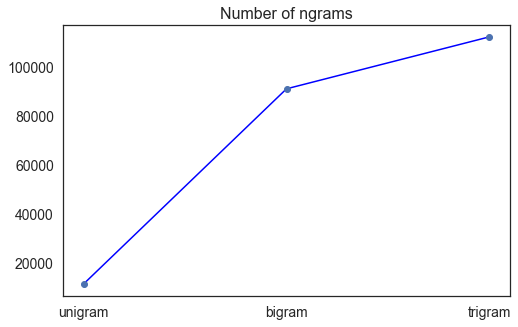

In [146]:
sns.set_style("white")
counts = [len(words), len(bigrams), len(trigrams)]
plt.plot(counts, color='blue')
plt.plot(counts, 'bo')
#plt.margins(0.1)
plt.ticklabel_format(style = 'plain')
plt.xticks(range(3), ['unigram', 'bigram', 'trigram'])
plt.tick_params(labelsize=14)
plt.title('Number of ngrams', {'fontsize':16})
plt.show()

## Model Training and Selection

In [189]:
business = load_rows('yelp_academic_dataset_business.json',10000)
review = load_rows('yelp_academic_dataset_review.json',10000)
business = business[business['is_open']==1] #selecting only open restaurants
business = business.drop(['hours','is_open','address', 'postal_code', 'attributes', 'review_count',  'city', 'latitude','longitude'], axis=1)
#filter for restaurnats
business_res = business[business['categories'].str.contains(
              'Restaurants',
              case=False, na=False)]
business_res = business_res.rename(columns={'stars': 'business_stars'})
#removing columns that might not be relevant
review = review.drop(['useful','user_id','funny', 'cool', 'date'], axis=1)
review = review.rename(columns={'stars': 'review_stars'})
final = pd.merge(business_res, review, on='business_id', how='inner')

#selecting stars and text of reviews
df1 = final[['review_stars', 'text']]

#We know from past analysis that there is foreign language in this dataset. 
language = [detect_langs(i) for i in df1.text]
languages = [str(i[0]).split(':')[0] for i in language]
df1['language'] = languages
df1 = df1.loc[df1["language"].isin(["en"])]


# Create the dictionary 
label_dictionary ={1 : 1, 2 : 1, 3 : 1,
                   4 : 0, 5 : 0} 

# Add a new column named Label 
df1['label'] = df1['review_stars'].map(label_dictionary)

df2 = df1[['text', 'label']]

<ipython-input-189-771bcaef9f5e>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['language'] = languages


In [190]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"u": "you", #added this from the analysis
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [191]:
def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    # remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english") + list(ENGLISH_STOP_WORDS)+
                   ['will', 'still'])
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    # Tokenize each word
    text =  nltk.WordPunctTokenizer().tokenize(text)
        
    return text

In [192]:
df2['Text_Cleaned'] = list(map(clean_text, df2.text))

<ipython-input-192-345b2fcdfcfc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Text_Cleaned'] = list(map(clean_text, df2.text))


In [193]:
#Bag of words transformation
import sklearn.model_selection
training_data, test_data = sklearn.model_selection.train_test_split(df2, train_size = 0.7, random_state=42)

In [194]:
print(training_data.shape)
print(test_data.shape)

(1833, 3)
(787, 3)


In [195]:
#bag of words transforming training and test data
bow_transform = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[1,1], lowercase=False)
X_tr_bow = bow_transform.fit_transform(training_data['Text_Cleaned']) #training data
X_te_bow = bow_transform.transform(test_data['Text_Cleaned']) #test data

y_tr = training_data['label']
y_te = test_data['label']

In [196]:
#Tf-Idf Tranformation
from sklearn.feature_extraction import text

tfidf_transform = text.TfidfTransformer(norm=None)
X_tr_tfidf = tfidf_transform.fit_transform(X_tr_bow) #tfid on training data
X_te_tfidf = tfidf_transform.transform(X_te_bow) #tfid on test data

In [197]:
#NaiveBayes with bag of words transformation
#This is the best model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB

nb_classifier = MultinomialNB()
nb_classifier.fit(X_tr_bow, y_tr)
y_pred = nb_classifier.predict(X_te_bow)

print(confusion_matrix(y_te,y_pred))
print(classification_report(y_te,y_pred))
print(accuracy_score(y_te, y_pred))

[[503  32]
 [102 150]]
              precision    recall  f1-score   support

           0       0.83      0.94      0.88       535
           1       0.82      0.60      0.69       252

    accuracy                           0.83       787
   macro avg       0.83      0.77      0.79       787
weighted avg       0.83      0.83      0.82       787

0.829733163913596


In [168]:
#Hyperparameter tuning
text_clf = Pipeline([
    ('vect', CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)),
     ('tfidf', TfidfTransformer(norm = None)),
     ('clf', MultinomialNB()),
])

In [169]:
from sklearn.model_selection import GridSearchCV
#https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
parameters = {
     'vect__ngram_range': [(1, 1), (1, 2), (2,2)],
     'tfidf__use_idf': (True, False),
     #'clf__alpha': (1e-2, 1e-3),
    'clf__alpha': np.linspace(0.5, 1.5, 6),
    'clf__fit_prior': [True, False],
}

In [170]:
gs_clf = GridSearchCV(text_clf, parameters)
gs_clf.fit(training_data.Text_Cleaned,y_tr)

GridSearchCV(estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(lowercase=False,
                                                        tokenizer=<function <lambda> at 0x1275689d0>)),
                                       ('tfidf', TfidfTransformer(norm=None)),
                                       ('clf', MultinomialNB())]),
             param_grid={'clf__alpha': array([0.5, 0.7, 0.9, 1.1, 1.3, 1.5]),
                         'clf__fit_prior': [True, False],
                         'tfidf__use_idf': (True, False),
                         'vect__ngram_range': [(1, 1), (1, 2), (2, 2)]})

In [171]:
#Hyper parameter tuning
print("Best Score: ", gs_clf.best_score_)
print("Best Params: ", gs_clf.best_params_)

Best Score:  0.8418784711365227
Best Params:  {'clf__alpha': 0.9, 'clf__fit_prior': False, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 1)}


In [198]:
#NaiveBayes with bag of words transformation
#This is the best model after hyperparameter tuning

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB

nb_classifier = MultinomialNB(alpha = 0.9, fit_prior = False)
nb_classifier.fit(X_tr_bow, y_tr)
y_pred = nb_classifier.predict(X_te_bow)

print(confusion_matrix(y_te,y_pred))
print(classification_report(y_te,y_pred))
print(accuracy_score(y_te, y_pred))

[[495  40]
 [ 89 163]]
              precision    recall  f1-score   support

           0       0.85      0.93      0.88       535
           1       0.80      0.65      0.72       252

    accuracy                           0.84       787
   macro avg       0.83      0.79      0.80       787
weighted avg       0.83      0.84      0.83       787

0.8360864040660737


In [199]:
#NaiveBayes with Tf-Idf Tranformation
from sklearn.naive_bayes import MultinomialNB

nb_classifier = MultinomialNB()
nb_classifier.fit(X_tr_tfidf, y_tr)
y_pred = nb_classifier.predict(X_te_tfidf)

print(confusion_matrix(y_te,y_pred))
print(classification_report(y_te,y_pred))
print(accuracy_score(y_te, y_pred))

[[465  70]
 [ 92 160]]
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       535
           1       0.70      0.63      0.66       252

    accuracy                           0.79       787
   macro avg       0.77      0.75      0.76       787
weighted avg       0.79      0.79      0.79       787

0.7941550190597204


In [200]:
#Random Forest with Bag of words transformation
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier.fit(X_tr_bow, y_tr) 
y_pred = classifier.predict(X_te_bow)


print(confusion_matrix(y_te,y_pred))
print(classification_report(y_te,y_pred))
print(accuracy_score(y_te, y_pred))

[[512  23]
 [130 122]]
              precision    recall  f1-score   support

           0       0.80      0.96      0.87       535
           1       0.84      0.48      0.61       252

    accuracy                           0.81       787
   macro avg       0.82      0.72      0.74       787
weighted avg       0.81      0.81      0.79       787

0.8055908513341804


In [201]:
#Random Forest with Bag of words transformation, increasing n_estimator does not work
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=3000, random_state=0)
classifier.fit(X_tr_bow, y_tr) 
y_pred = classifier.predict(X_te_bow)


print(confusion_matrix(y_te,y_pred))
print(classification_report(y_te,y_pred))
print(accuracy_score(y_te, y_pred))

[[514  21]
 [132 120]]
              precision    recall  f1-score   support

           0       0.80      0.96      0.87       535
           1       0.85      0.48      0.61       252

    accuracy                           0.81       787
   macro avg       0.82      0.72      0.74       787
weighted avg       0.81      0.81      0.79       787

0.8055908513341804


In [202]:
#Random Forest with Tf-idftransformation
classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
classifier.fit(X_tr_tfidf, y_tr) 
y_pred = classifier.predict(X_te_tfidf)


print(confusion_matrix(y_te,y_pred))
print(classification_report(y_te,y_pred))
print(accuracy_score(y_te, y_pred))

[[512  23]
 [130 122]]
              precision    recall  f1-score   support

           0       0.80      0.96      0.87       535
           1       0.84      0.48      0.61       252

    accuracy                           0.81       787
   macro avg       0.82      0.72      0.74       787
weighted avg       0.81      0.81      0.79       787

0.8055908513341804


In [203]:
#Logistic Regression with Bag of words transformation
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_tr_bow, y_tr) 
y_pred = log_reg.predict(X_te_bow)


print(confusion_matrix(y_te,y_pred))
print(classification_report(y_te,y_pred))
print(accuracy_score(y_te, y_pred))

[[485  50]
 [ 75 177]]
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       535
           1       0.78      0.70      0.74       252

    accuracy                           0.84       787
   macro avg       0.82      0.80      0.81       787
weighted avg       0.84      0.84      0.84       787

0.841168996188056


In [204]:
#Logistic Regression TF-IDF  transformation
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_tr_tfidf, y_tr) 
y_pred = log_reg.predict(X_te_tfidf)


print(confusion_matrix(y_te,y_pred))
print(classification_report(y_te,y_pred))
print(accuracy_score(y_te, y_pred))

[[489  46]
 [ 73 179]]
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       535
           1       0.80      0.71      0.75       252

    accuracy                           0.85       787
   macro avg       0.83      0.81      0.82       787
weighted avg       0.85      0.85      0.85       787

0.8487928843710292


In [205]:
#bag of words transforming training and test data. Using 2 gram
bow_transform = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[1,2], lowercase=False)
X_tr_bow = bow_transform.fit_transform(training_data['Text_Cleaned']) #training data
X_te_bow = bow_transform.transform(test_data['Text_Cleaned']) #test data

y_tr = training_data['label']
y_te = test_data['label']

#Tf-Idf Tranformation
from sklearn.feature_extraction import text

tfidf_transform = text.TfidfTransformer(norm=None)
X_tr_tfidf = tfidf_transform.fit_transform(X_tr_bow) #tfid on training data
X_te_tfidf = tfidf_transform.transform(X_te_bow) #tfid on test data



#NaiveBayes with bag of words transformation
from sklearn.naive_bayes import MultinomialNB

nb_classifier = MultinomialNB()
nb_classifier.fit(X_tr_bow, y_tr)
y_pred = nb_classifier.predict(X_te_bow)

print(confusion_matrix(y_te,y_pred))
print(classification_report(y_te,y_pred))
print(accuracy_score(y_te, y_pred))



#NaiveBayes with Tf-Idf Tranformation
from sklearn.naive_bayes import MultinomialNB

nb_classifier = MultinomialNB()
nb_classifier.fit(X_tr_tfidf, y_tr)
y_pred = nb_classifier.predict(X_te_tfidf)

print(confusion_matrix(y_te,y_pred))
print(classification_report(y_te,y_pred))
print(accuracy_score(y_te, y_pred))

[[526   9]
 [154  98]]
              precision    recall  f1-score   support

           0       0.77      0.98      0.87       535
           1       0.92      0.39      0.55       252

    accuracy                           0.79       787
   macro avg       0.84      0.69      0.71       787
weighted avg       0.82      0.79      0.76       787

0.7928843710292249
[[490  45]
 [107 145]]
              precision    recall  f1-score   support

           0       0.82      0.92      0.87       535
           1       0.76      0.58      0.66       252

    accuracy                           0.81       787
   macro avg       0.79      0.75      0.76       787
weighted avg       0.80      0.81      0.80       787

0.806861499364676


In [206]:
#bag of words transforming training and test data. Using 2 gram
bow_transform = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[2,2], lowercase=False)
X_tr_bow = bow_transform.fit_transform(training_data['Text_Cleaned']) #training data
X_te_bow = bow_transform.transform(test_data['Text_Cleaned']) #test data

y_tr = training_data['label']
y_te = test_data['label']

#Tf-Idf Tranformation
from sklearn.feature_extraction import text

tfidf_transform = text.TfidfTransformer(norm=None)
X_tr_tfidf = tfidf_transform.fit_transform(X_tr_bow) #tfid on training data
X_te_tfidf = tfidf_transform.transform(X_te_bow) #tfid on test data



#NaiveBayes with bag of words transformation
from sklearn.naive_bayes import MultinomialNB

nb_classifier = MultinomialNB()
nb_classifier.fit(X_tr_bow, y_tr)
y_pred = nb_classifier.predict(X_te_bow)

print(confusion_matrix(y_te,y_pred))
print(classification_report(y_te,y_pred))
print(accuracy_score(y_te, y_pred))



#NaiveBayes with Tf-Idf Tranformation
from sklearn.naive_bayes import MultinomialNB

nb_classifier = MultinomialNB()
nb_classifier.fit(X_tr_tfidf, y_tr)
y_pred = nb_classifier.predict(X_te_tfidf)

print(confusion_matrix(y_te,y_pred))
print(classification_report(y_te,y_pred))
print(accuracy_score(y_te, y_pred))

[[495  40]
 [151 101]]
              precision    recall  f1-score   support

           0       0.77      0.93      0.84       535
           1       0.72      0.40      0.51       252

    accuracy                           0.76       787
   macro avg       0.74      0.66      0.68       787
weighted avg       0.75      0.76      0.73       787

0.7573062261753494
[[463  72]
 [123 129]]
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       535
           1       0.64      0.51      0.57       252

    accuracy                           0.75       787
   macro avg       0.72      0.69      0.70       787
weighted avg       0.74      0.75      0.74       787

0.7522236340533672


In [207]:
#bag of words transforming training and test data. Using 3 gram
bow_transform = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[3,3], lowercase=False)
X_tr_bow = bow_transform.fit_transform(training_data['Text_Cleaned']) #training data
X_te_bow = bow_transform.transform(test_data['Text_Cleaned']) #test data

y_tr = training_data['label']
y_te = test_data['label']

#Tf-Idf Tranformation
from sklearn.feature_extraction import text

tfidf_transform = text.TfidfTransformer(norm=None)
X_tr_tfidf = tfidf_transform.fit_transform(X_tr_bow) #tfid on training data
X_te_tfidf = tfidf_transform.transform(X_te_bow) #tfid on test data



#NaiveBayes with bag of words transformation
from sklearn.naive_bayes import MultinomialNB

nb_classifier = MultinomialNB()
nb_classifier.fit(X_tr_bow, y_tr)
y_pred = nb_classifier.predict(X_te_bow)

print(confusion_matrix(y_te,y_pred))
print(classification_report(y_te,y_pred))
print(accuracy_score(y_te, y_pred))



#NaiveBayes with Tf-Idf Tranformation
from sklearn.naive_bayes import MultinomialNB

nb_classifier = MultinomialNB()
nb_classifier.fit(X_tr_tfidf, y_tr)
y_pred = nb_classifier.predict(X_te_tfidf)

print(confusion_matrix(y_te,y_pred))
print(classification_report(y_te,y_pred))
print(accuracy_score(y_te, y_pred))

[[503  32]
 [203  49]]
              precision    recall  f1-score   support

           0       0.71      0.94      0.81       535
           1       0.60      0.19      0.29       252

    accuracy                           0.70       787
   macro avg       0.66      0.57      0.55       787
weighted avg       0.68      0.70      0.65       787

0.7013977128335451
[[473  62]
 [181  71]]
              precision    recall  f1-score   support

           0       0.72      0.88      0.80       535
           1       0.53      0.28      0.37       252

    accuracy                           0.69       787
   macro avg       0.63      0.58      0.58       787
weighted avg       0.66      0.69      0.66       787

0.6912325285895807


In [208]:
#using Lemetization 
#bag of words transforming training and test data
#using lemmetization
def lemmatized_words(text):
    lemm = nltk.stem.WordNetLemmatizer()
    df2['lemmatized_text'] = list(map(lambda word:
                                     list(map(lemm.lemmatize, word)),
                                     df2.Text_Cleaned))
    

lemmatized_words(df2.Text_Cleaned)

training_data, test_data = sklearn.model_selection.train_test_split(df2, train_size = 0.7, random_state=42)
bow_transform = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[1,1], lowercase=False)
X_tr_bow = bow_transform.fit_transform(training_data['lemmatized_text']) #training data
X_te_bow = bow_transform.transform(test_data['lemmatized_text']) #test data

y_tr = training_data['label']
y_te = test_data['label']

#tf-idf
tfidf_transform = text.TfidfTransformer(norm=None)
X_tr_tfidf = tfidf_transform.fit_transform(X_tr_bow) #tfid on training data
X_te_tfidf = tfidf_transform.transform(X_te_bow) #tfid on test data



nb_classifier = MultinomialNB()
nb_classifier.fit(X_tr_bow, y_tr)
y_pred = nb_classifier.predict(X_te_bow)

print(confusion_matrix(y_te,y_pred))
print(classification_report(y_te,y_pred))
print(accuracy_score(y_te, y_pred))



nb_classifier = MultinomialNB()
nb_classifier.fit(X_tr_tfidf, y_tr)
y_pred = nb_classifier.predict(X_te_tfidf)

print(confusion_matrix(y_te,y_pred))
print(classification_report(y_te,y_pred))
print(accuracy_score(y_te, y_pred))

[[503  32]
 [101 151]]
              precision    recall  f1-score   support

           0       0.83      0.94      0.88       535
           1       0.83      0.60      0.69       252

    accuracy                           0.83       787
   macro avg       0.83      0.77      0.79       787
weighted avg       0.83      0.83      0.82       787

0.8310038119440915
[[466  69]
 [ 88 164]]
              precision    recall  f1-score   support

           0       0.84      0.87      0.86       535
           1       0.70      0.65      0.68       252

    accuracy                           0.80       787
   macro avg       0.77      0.76      0.77       787
weighted avg       0.80      0.80      0.80       787

0.8005082592121983
